# Tabular Evaluation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento dei dataset
original_data = pd.read_csv('./TabularData/diabetic_data_filtered_250.csv')
synthetic_data = pd.read_csv('TabularData/ClassicPrompt/GPT_synthetic_diabetic_patients.csv')

## 1. Visualizzazione delle Distribuzioni

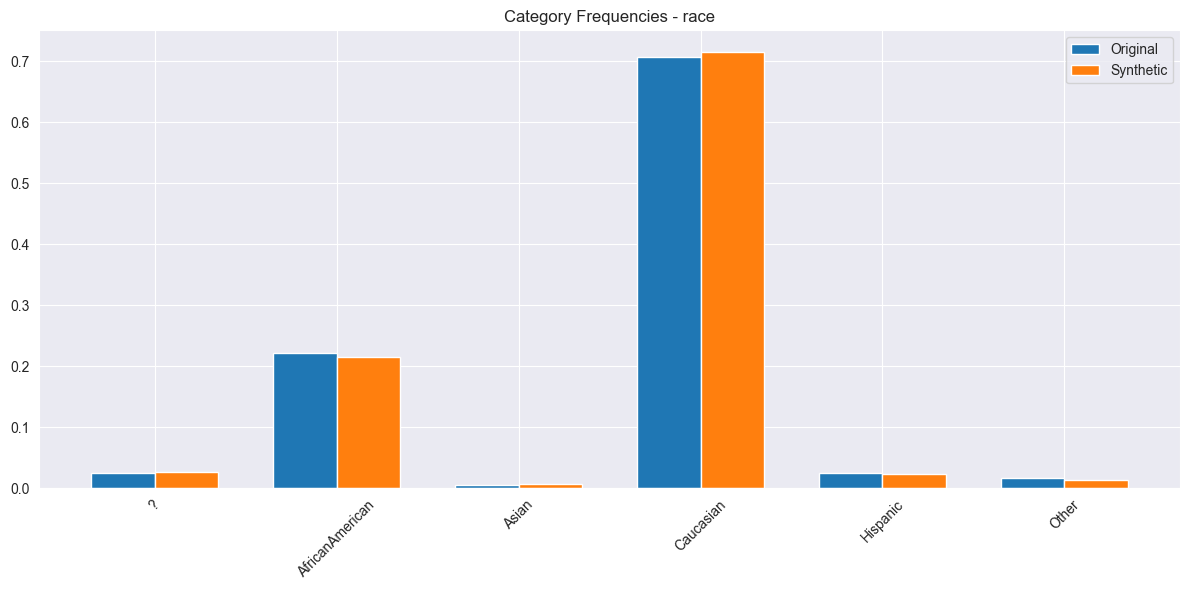

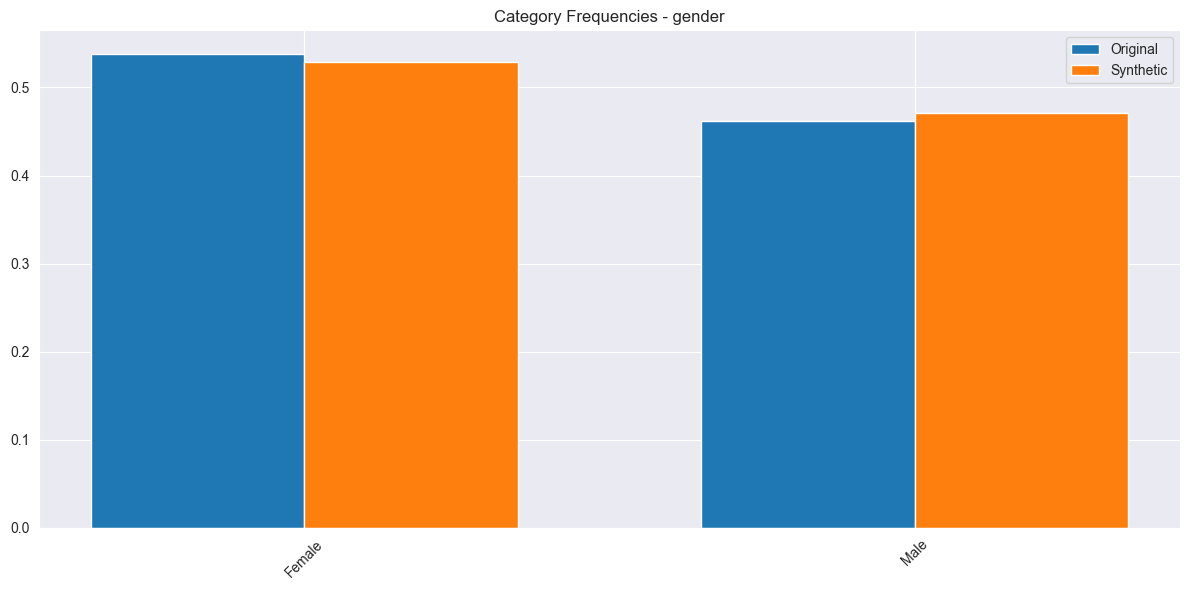

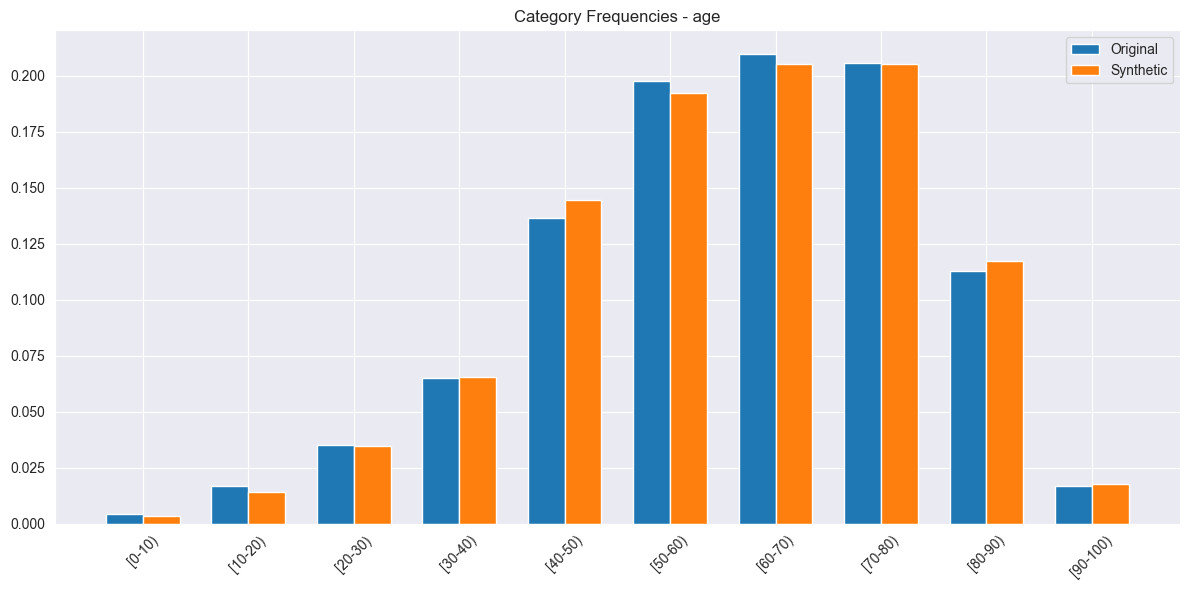

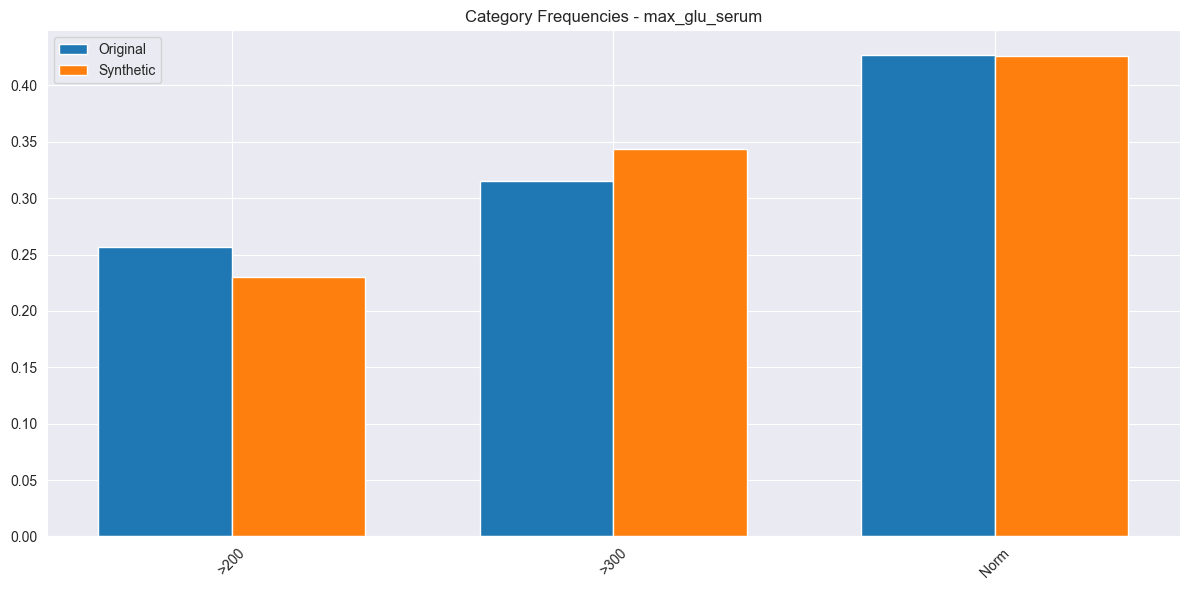

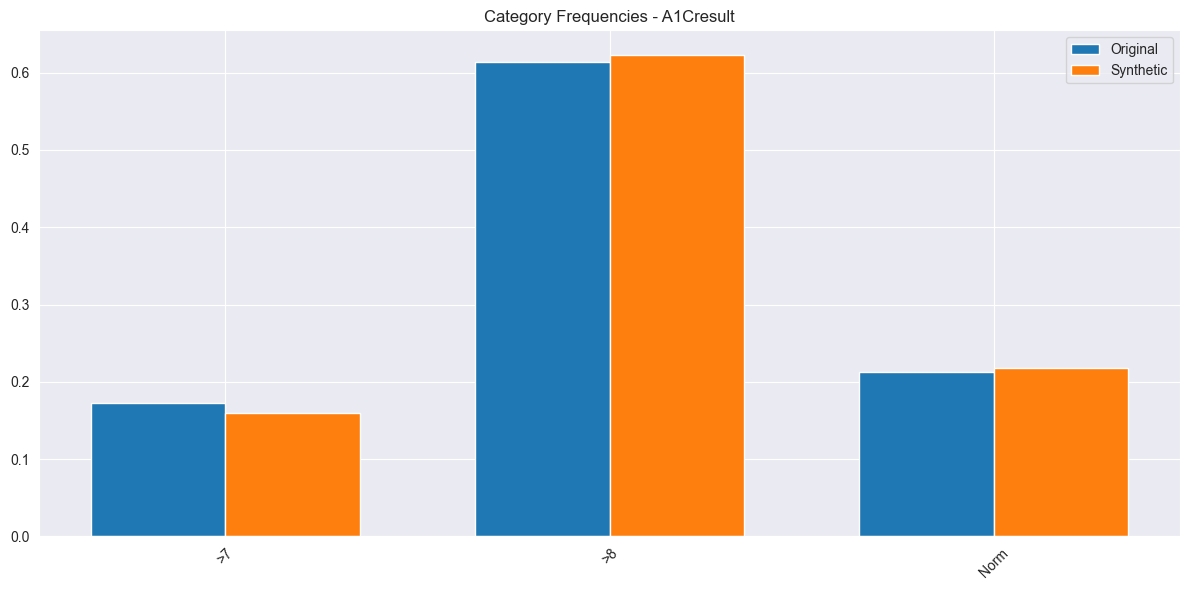

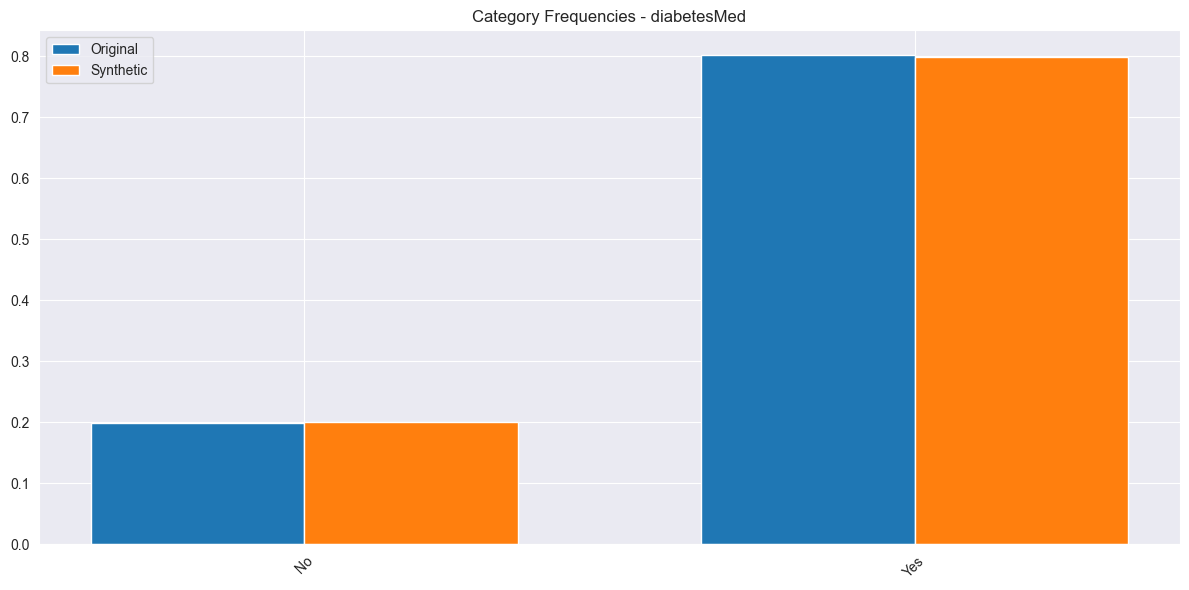

In [11]:
def plot_feature_distributions(df1, df2, column):
    """Visualizza le distribuzioni di una feature nei due dataset"""
    plt.figure(figsize=(12, 6))

    if pd.api.types.is_numeric_dtype(df1[column]):
        # Per variabili numeriche: plot delle distribuzioni
        sns.kdeplot(data=df1, x=column, label='Original', alpha=0.5)
        sns.kdeplot(data=df2, x=column, label='Synthetic', alpha=0.5)
        plt.title(f'Distribution Comparison - {column}')
    else:
        # Per variabili categoriche: plot delle frequenze relative
        freq1 = df1[column].value_counts(normalize=True)
        freq2 = df2[column].value_counts(normalize=True)

        # Combina le categorie
        categories = sorted(set(freq1.index) | set(freq2.index))

        x = np.arange(len(categories))
        width = 0.35

        plt.bar(x - width/2, [freq1.get(cat, 0) for cat in categories], width, label='Original')
        plt.bar(x + width/2, [freq2.get(cat, 0) for cat in categories], width, label='Synthetic')
        plt.xticks(x, categories, rotation=45)
        plt.title(f'Category Frequencies - {column}')

    plt.legend()
    plt.tight_layout()
    plt.show()

columns_to_plot = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'diabetesMed']

for column in columns_to_plot:
    if column in original_data.columns and column in synthetic_data.columns:
        plot_feature_distributions(original_data, synthetic_data, column)
    else:
        print(f"Attenzione: la colonna {column} non è presente in entrambi i dataset")

## 2. Pulizia delle colonne non rilevanti

In [12]:
original_data = original_data.drop(["encounter_id", "patient_nbr"], axis=1)
if "encounter_id" in synthetic_data.columns or "patient_nbr" in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(["encounter_id", "patient_nbr"], axis=1)

# TODO togliere l'id del ricovero e il payer code, RICORDATIIIIII !

### 2.1 Controlla se hai delle righe uguali

In [37]:
merged = pd.merge(original_data, synthetic_data, how='right', indicator='Exist')
merged['Exist'] = np.where(merged.Exist == 'both', True, False)
print(merged['Exist'].value_counts())

Exist
False    7604
Name: count, dtype: int64


## 3. Funzioni di Similarità per Diversi Tipi di Dati

### 3.1 Similarità con Differenze Assolute e Distanza Euclidea Normalizzata

In [13]:
def calculate_numerical_similarity(series1, series2):
    """Calcola la similarità per variabili numeriche usando statistiche descrittive normalizzate"""
    stats1 = series1.describe()
    stats2 = series2.describe()

    # Confronto di media, std e percentili
    diff_mean = abs(stats1['mean'] - stats2['mean']) / max(abs(stats1['mean']), 1)
    diff_std = abs(stats1['std'] - stats2['std']) / max(abs(stats1['std']), 1)

    # Similarità come 1 - media delle differenze normalizzate
    similarity = 1 - np.mean([diff_mean, diff_std])
    return similarity

def calculate_categorical_similarity(series1, series2):
    """Calcola la similarità per variabili categoriche usando distribuzione delle frequenze"""
    # Calcolo delle frequenze relative
    freq1 = series1.value_counts(normalize=True)
    freq2 = series2.value_counts(normalize=True)

    # Unione di tutte le categorie
    all_categories = set(freq1.index) | set(freq2.index)

    # Normalizzazione delle frequenze
    freq1 = freq1.reindex(all_categories).fillna(0)
    freq2 = freq2.reindex(all_categories).fillna(0)

    # Calcolo della similarità usando la distanza di Jensen-Shannon
    similarity = 1 - np.sqrt(np.mean((freq1 - freq2) ** 2))
    return similarity

def calculate_overall_similarity(df1, df2):
    """Calcola la similarità complessiva tra i due dataset"""
    similarities = {}

    for column in df1.columns:
        if column in df2.columns:
            if pd.api.types.is_numeric_dtype(df1[column]):
                similarity = calculate_numerical_similarity(df1[column], df2[column])
                similarities[column] = {'type': 'numerical', 'similarity': similarity}
            else:
                similarity = calculate_categorical_similarity(df1[column], df2[column])
                similarities[column] = {'type': 'categorical', 'similarity': similarity}

    # Crea DataFrame dei risultati
    results = pd.DataFrame.from_dict(similarities, orient='index')

    # Calcola similarità media complessiva
    overall_similarity = results['similarity'].mean()

    return results, overall_similarity

# Calcola e visualizza i risultati
similarity_results, overall = calculate_overall_similarity(original_data, synthetic_data)
print(f"\nSimilarità complessiva tra i dataset: {overall:.2%}")
print("\nSimilarità per feature:")
print(similarity_results.sort_values('similarity', ascending=False))


Similarità complessiva tra i dataset: 99.57%

Similarità per feature:
                                 type  similarity
citoglipton               categorical    1.000000
examide                   categorical    1.000000
metformin-rosiglitazone   categorical    1.000000
acetohexamide             categorical    1.000000
tolazamide                categorical    1.000000
glimepiride-pioglitazone  categorical    0.999974
troglitazone              categorical    0.999974
metformin-pioglitazone    categorical    0.999974
glipizide-metformin       categorical    0.999895
miglitol                  categorical    0.999888
chlorpropamide            categorical    0.999830
weight                    categorical    0.999818
tolbutamide               categorical    0.999790
repaglinide               categorical    0.999670
acarbose                  categorical    0.999655
diag_1                    categorical    0.999590
diag_2                    categorical    0.999588
diag_3                    cat

### 3.2 Similarità con KS-statistic e Jensen-Shannon

In [14]:
from scipy.stats import ks_2samp
from scipy.stats import entropy

def calculate_numerical_similarity_ks(series1, series2):
    """
    Calcola la similarità per variabili numeriche usando il test KS.
    """
    # Rimuove i valori NaN
    s1 = series1.dropna()
    s2 = series2.dropna()

    # Calcola la KS statistic
    ks_statistic, _ = ks_2samp(s1, s2)

    # Converte la distanza in similarità
    similarity = 1 - ks_statistic
    return similarity

def calculate_categorical_similarity_js(series1, series2):
    """
    Calcola la similarità per variabili categoriche usando Jensen-Shannon
    """
    # Calcolo delle frequenze relative
    freq1 = series1.value_counts(normalize=True)
    freq2 = series2.value_counts(normalize=True)

    # Unione di tutte le categorie
    all_categories = sorted(set(freq1.index) | set(freq2.index))

    # Normalizzazione delle frequenze con zero-padding
    p = np.array([freq1.get(cat, 0) for cat in all_categories])
    q = np.array([freq2.get(cat, 0) for cat in all_categories])

    # Calcolo della distribuzione media
    m = 0.5 * (p + q)

    # Calcolo della Jensen-Shannon divergence
    # Aggiungiamo un epsilon per evitare log(0)
    eps = 1e-10
    js_divergence = 0.5 * (
        entropy(p + eps, m + eps) +
        entropy(q + eps, m + eps)
    )

    # Convertiamo la divergenza in similarità
    # Normalizziamo
    similarity = 1 - (js_divergence / np.log(2))
    return similarity

def calculate_overall_similarity(df1, df2):
    """Calcola la similarità complessiva tra i due dataset"""
    similarities = {}

    for column in df1.columns:
        if column in df2.columns:
            if pd.api.types.is_numeric_dtype(df1[column]):
                similarity = calculate_numerical_similarity_ks(df1[column], df2[column])
                similarities[column] = {'type': 'numerical (KS)', 'similarity': similarity}
            else:
                similarity = calculate_categorical_similarity_js(df1[column], df2[column])
                similarities[column] = {'type': 'categorical (JS)', 'similarity': similarity}

    # Crea DataFrame dei risultati
    results = pd.DataFrame.from_dict(similarities, orient='index')

    # Calcola similarità media complessiva
    overall_similarity = results['similarity'].mean()

    return results, overall_similarity

similarity_results, overall = calculate_overall_similarity(original_data, synthetic_data)
print(f"\nSimilarità complessiva tra i dataset: {overall:.2%}")
print("\nSimilarità per feature:")
print(similarity_results.sort_values('similarity', ascending=False))



Similarità complessiva tra i dataset: 99.73%

Similarità per feature:
                                      type  similarity
citoglipton               categorical (JS)    1.000000
examide                   categorical (JS)    1.000000
metformin-rosiglitazone   categorical (JS)    1.000000
acetohexamide             categorical (JS)    1.000000
tolazamide                categorical (JS)    1.000000
change                    categorical (JS)    0.999997
diabetesMed               categorical (JS)    0.999990
glimepiride-pioglitazone  categorical (JS)    0.999987
metformin-pioglitazone    categorical (JS)    0.999987
troglitazone              categorical (JS)    0.999987
acarbose                  categorical (JS)    0.999985
glimepiride               categorical (JS)    0.999976
tolbutamide               categorical (JS)    0.999972
glyburide                 categorical (JS)    0.999963
chlorpropamide            categorical (JS)    0.999962
metformin                 categorical (JS)    0.9